# FD004 Branch 2: XGBoost 기반 Phase 1 개선 실험

## 📋 실험 개요

- **Dataset**: FD004
- **Best Model from Branch 1**: XGBoost (Test RMSE: 72.29, R²: 0.38)
- **실험 목적**: Phase 1 개선 기법들의 효과 검증

---

## 🎯 4가지 실험 조건

1. **Baseline**: 개선 없음 (원본 데이터)
2. **RUL Clipping**: RUL ≤ 125로 제한
3. **Sensor Removal**: Noise 센서 8개 제거
4. **Both**: RUL Clipping + Sensor Removal 동시 적용

---

## 📊 제거 대상 Noise 센서

```python
NOISE_SENSORS = ['s_1', 's_5', 's_8', 's_14', 's_15', 's_16', 's_18', 's_19']
```

## 1. 환경 설정 및 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# 시드 고정
np.random.seed(42)

## 2. 데이터 로드 및 스케일링

In [2]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.preprocessing import StandardScaler

# 경로 설정
DATA_PATH = '/content/drive/MyDrive/ML project'

# FD004 데이터 로드
train_fd004 = pd.read_csv(f'{DATA_PATH}/FD004_train_df.csv')
test_fd004 = pd.read_csv(f'{DATA_PATH}/FD004_test_df.csv')

## 3. 센서 컬럼 정의 및 스케일링

In [4]:
# Noise 센서 정의
NOISE_SENSORS = ['s_1', 's_5', 's_8', 's_14', 's_15', 's_16', 's_18', 's_19']

# 전체 센서 (21개)
ALL_SENSORS = [f's_{i}' for i in range(1, 22)]

# 신호 센서 (Noise 제거 후 13개)
SIGNAL_SENSORS = [s for s in ALL_SENSORS if s not in NOISE_SENSORS]

In [5]:
# Standard Scaler 적용
scaler = StandardScaler()

# Train 데이터 스케일링
train_fd004_scaled = train_fd004.copy()
train_fd004_scaled[ALL_SENSORS] = scaler.fit_transform(train_fd004[ALL_SENSORS])

# Test 데이터 스케일링
test_fd004_scaled = test_fd004.copy()
test_fd004_scaled[ALL_SENSORS] = scaler.transform(test_fd004[ALL_SENSORS])

## 4. 데이터 전처리 함수

In [6]:
def apply_rul_clipping(df, max_rul=125):
    df_clipped = df.copy()
    df_clipped['RUL'] = df_clipped['RUL'].clip(upper=max_rul)
    return df_clipped

def remove_noise_sensors(df, noise_sensors):
    cols_to_keep = [col for col in df.columns if col not in noise_sensors]
    return df[cols_to_keep].copy()

def prepare_data(df, sensor_cols):
    X = df[sensor_cols].values
    y = df['RUL'].values
    return X, y

## 5. XGBoost 모델 정의

In [7]:
def build_xgboost_model():
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    return model

## 6. 실험 실행 함수

In [8]:
def run_experiment(train_data, test_data, sensor_cols, condition_name):
    # 데이터 준비
    X_train, y_train = prepare_data(train_data, sensor_cols)
    X_test, y_test = prepare_data(test_data, sensor_cols)

    # 모델 생성 및 학습
    model = build_xgboost_model()
    model.fit(X_train, y_train, verbose=False)

    # 예측
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 평가
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return {
        'condition': condition_name,
        'n_sensors': len(sensor_cols),
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'overfit': test_rmse - train_rmse
    }

## 7. 4가지 실험 조건 실행

### 7.1 Condition 1: Baseline (개선 없음)

In [9]:
# Baseline: 원본 데이터 (Standard Scaler 적용)
result_baseline = run_experiment(
    train_data=train_fd004_scaled,
    test_data=test_fd004_scaled,
    sensor_cols=ALL_SENSORS,
    condition_name='1. Baseline'
)

### 7.2 Condition 2: RUL Clipping

In [10]:
# RUL Clipping 적용 (스케일링된 데이터 사용)
train_clipped = apply_rul_clipping(train_fd004_scaled, max_rul=125)
test_clipped = apply_rul_clipping(test_fd004_scaled, max_rul=125)

result_rul = run_experiment(
    train_data=train_clipped,
    test_data=test_clipped,
    sensor_cols=ALL_SENSORS,
    condition_name='2. RUL Clipping'
)

### 7.3 Condition 3: Sensor Removal

In [11]:
# Noise 센서 제거 (스케일링된 데이터 사용)
train_no_noise = remove_noise_sensors(train_fd004_scaled, NOISE_SENSORS)
test_no_noise = remove_noise_sensors(test_fd004_scaled, NOISE_SENSORS)

result_sensor = run_experiment(
    train_data=train_no_noise,
    test_data=test_no_noise,
    sensor_cols=SIGNAL_SENSORS,
    condition_name='3. Sensor Removal'
)

### 7.4 Condition 4: Both (RUL Clipping + Sensor Removal)

In [12]:
# Both: RUL Clipping + Sensor Removal (스케일링된 데이터 사용)
train_both = apply_rul_clipping(train_fd004_scaled, max_rul=125)
train_both = remove_noise_sensors(train_both, NOISE_SENSORS)

test_both = apply_rul_clipping(test_fd004_scaled, max_rul=125)
test_both = remove_noise_sensors(test_both, NOISE_SENSORS)

result_both = run_experiment(
    train_data=train_both,
    test_data=test_both,
    sensor_cols=SIGNAL_SENSORS,
    condition_name='4. Both'
)

## 8. 결과 비교 및 시각화

In [13]:
# 결과 정리
results = [result_baseline, result_rul, result_sensor, result_both]
df_results = pd.DataFrame(results)

# 개선율 계산
baseline_rmse = df_results.loc[0, 'test_rmse']
df_results['improvement_%'] = ((baseline_rmse - df_results['test_rmse']) / baseline_rmse * 100).round(2)

df_results

,condition,n_sensors,train_rmse,test_rmse,test_mae,test_r2,overfit,improvement_%
0,1. Baseline,21,46.771328,72.335998,53.407799,0.384043,25.564670,0.00
1,2. RUL Clipping,21,14.445252,16.243659,10.413715,0.593073,1.798407,77.54
2,3. Sensor Removal,13,47.667599,72.908202,53.830616,0.374259,25.240604,-0.79
3,4. Both,13,14.856433,16.489029,10.609065,0.580687,1.632596,77.20


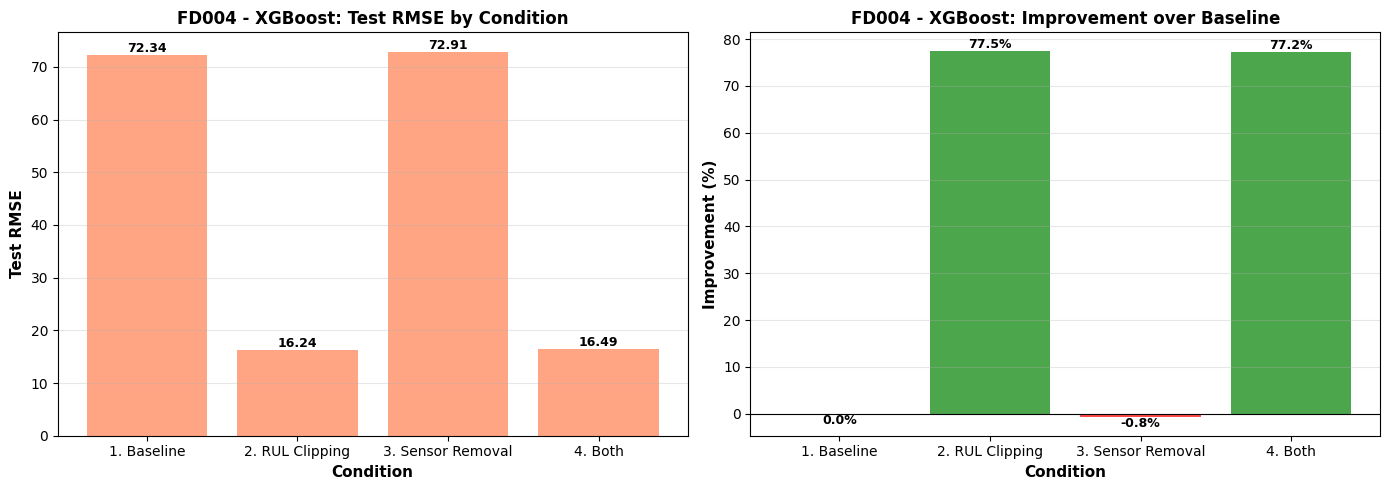

In [14]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test RMSE 비교
ax1 = axes[0]
bars1 = ax1.bar(df_results['condition'], df_results['test_rmse'], color='coral', alpha=0.7)
ax1.set_xlabel('Condition', fontsize=11, fontweight='bold')
ax1.set_ylabel('Test RMSE', fontsize=11, fontweight='bold')
ax1.set_title('FD004 - XGBoost: Test RMSE by Condition', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x')

# 값 표시
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 개선율 비교
ax2 = axes[1]
colors = ['gray' if x == 0 else 'green' if x > 0 else 'red' for x in df_results['improvement_%']]
bars2 = ax2.bar(df_results['condition'], df_results['improvement_%'], color=colors, alpha=0.7)
ax2.set_xlabel('Condition', fontsize=11, fontweight='bold')
ax2.set_ylabel('Improvement (%)', fontsize=11, fontweight='bold')
ax2.set_title('FD004 - XGBoost: Improvement over Baseline', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x')

# 값 표시
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom' if height > 0 else 'top',
             fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()